Implémentation du papier de recherche "Model-based clustering based on sparse finite Gaussian mixtures" Gertraud Malsiner-Walli · Sylvia Frühwirth-Schnatter · Bettina Grün

In [12]:
import numpy as np
from scipy.stats import dirichlet, wishart, multivariate_normal, geninvgauss, mode
from scipy.cluster.vq import kmeans2

In [17]:
class SparseGaussianMixture:
    def __init__(self, K, e0, c0, nu1, nu2):
        self.K = K
        self.e0 = e0
        self.c0 = c0
        self.nu1 = nu1
        self.nu2 = nu2
    
    def fit(self, y, max_iter=10000, burn_in=1000):
        """On entraine le Sparse Gaussian Mixture Model"""

        N, r = y.shape

        # hyperparamètres
        R = np.ptp(y, axis=0) # Définis la plage des données
        R = np.maximum(R, 1e-6)
        R0 = np.diag(R**2)
        g0 = 0.5 + (r - 1) / 2
        G0 = (100 * g0 / self.c0) * np.diag(1 / R**2) #hyperparamètre de C0 avec wishart
        m0 = np.median(y, axis=0) #

        # C0 est initialisé à G0 (mais variera ensuite)
        C0 = G0.copy()

        # initialisation avec kmeans
        centroids, labels = kmeans2(y, self.K, minit='points')
        S = labels

        self.eta = np.ones(self.K) / self.K #On intialise les poids des clusters de manière uniforme
        mu = centroids # On initialise les moyennes des clusters avec les centroïdes de kmeans
        Sigma_inv = np.array([np.eye(r) for _ in range(self.K)]) # On initialise les matrices de précision comme des matrices identité
        lamb = np.ones(r) # On initialise les paramètres de sparsité à 1
        b0 = m0

        Nk = np.zeros(self.K)
        y_bar = np.zeros((self.K, r))
        
        # On initi
        self.trace_mu = []
        self.list_S_counts = []
        self.trace_eta = []
        self.trace_Nk = []
        self.trace_lambda = []  # Pour Figure 7 du papier
        self.trace_sigma = []

        #On démarre la boucle de Gibbs sampling de l'appendix 1
        for i in range(max_iter):
            
            # On met à jour les Nk, le nombre de points dans chaque cluster, et y_bar, la moyenne des points dans chaque cluster
            for k in range(self.K):
                Nk[k] = np.sum(S == k)
                if Nk[k] > 0:
                    y_bar[k] = np.mean(y[S == k], axis=0)
            
            #1a) On définit les ek, paramètres de la loi de Dirichlet
            ek = self.e0 + Nk
            self.eta = dirichlet.rvs(ek)[0] # On échantillonne les poids des clusters à partir de la loi de Dirichlet

            #1b) On échantillonne les matrices de précision des clusters
            Sigma = []
            for k in range(self.K):
                nk = Nk[k]
                ck = self.c0 + nk/2
                
                #On distingue 2 cas selon que le cluster k contient des points ou non
                if Nk[k] > 0:
                    diff = y[(S == k)] - mu[k]
                    sum = diff.T @ diff
                else:
                    sum = np.zeros((r, r))

                # on update les paramètres de wishart
                ck = self.c0 + Nk[k] / 2
                Ck = C0 + sum /2

                #On ajoute une petite régularisation pour que la matrice soit définie positive
                Ck += 1e-6 * np.eye(r)
                Ck = (Ck + Ck.T) / 2

                # Sampling. Scipy prend scale matrix, donc inv(Ck)
                scale_mat = np.linalg.inv(Ck)
                scale_mat = (scale_mat + scale_mat.T) / 2
                Sigma_k_inv = wishart.rvs(df=ck, scale=scale_mat)

                Sigma_inv[k] = Sigma_k_inv
                Sigma.append(np.linalg.inv(Sigma_k_inv))

            Sigma = np.array(Sigma)

            #1c) On échantillonne les moyennes des clusters
            B0_inv = np.diag(1 / (R**2 * lamb)) #l'inverse de B0
            for k in range(self.K):

                Bk_inv = B0_inv + Nk[k] * Sigma_inv[k]
                Bk = np.linalg.inv(Bk_inv)
                prior_part = B0_inv @ b0
                data_part = Sigma_inv[k] @ (Nk[k] * y_bar[k])
                
                bk = Bk @ (prior_part + data_part)
                mu[k] = multivariate_normal.rvs(mean=bk, cov=Bk)

            #2) Classificatipon des observations
            log_probs = np.zeros((N, self.K)) #On passe par le log pour éviter les underflows
            for k in range(self.K):
                try:
                    log_pdf = multivariate_normal.logpdf(y, mean=mu[k], cov=Sigma[k])
                    log_probs[:, k] = np.log(self.eta[k] + 1e-10) + log_pdf
                except np.linalg.LinAlgError:
                    log_probs[:, k] = -np.inf # Composante dégénérée

            max_log = np.max(log_probs, axis=1, keepdims=True)
            probs = np.exp(log_probs - max_log)
            row_sums = np.sum(probs, axis=1, keepdims=True)
            # Gestion des cas où la proba est nulle partout (outliers extrêmes)
            probs = np.divide(probs, row_sums, out=np.ones_like(probs)/self.K, where=row_sums!=0)
            
            S = np.array([np.argmax(np.random.multinomial(1, p)) for p in probs]) #échantillonnage des nouvelles affectations

            #3) On échantillonne les paramètres de sparsité

            #3a) On échantillonne les C0
            # C0 ~ Wishart(g0 + K*c0, (G0 + sum(Sigma_k_inv))^{-1})
            df_C0 = g0 + self.K * self.c0
            sum_Sigma_inv = np.sum(Sigma_inv, axis=0)
            scale_C0_inv = G0 + sum_Sigma_inv
            scale_C0_inv = (scale_C0_inv + scale_C0_inv.T) / 2 + 1e-6 * np.eye(r)
            scale_C0 = np.linalg.inv(scale_C0_inv)
            scale_C0 = (scale_C0 + scale_C0.T) / 2
            C0 = wishart.rvs(df=df_C0, scale=scale_C0)

            #3b) On échantillonne le e0 avec Metropolis-Hastings or dans ce cas on fixe e0

            #3c) On échantillonne les lambdas
            pK = self.nu1 - self.K / 2
            aj = 2 * self.nu2
            for j in range(r):
                bj = np.sum((mu[:, j] - b0[j])**2) / R[j]**2 
                bj = max(bj, 1e-10) # Pour éviter les divisions par zéro
                b_scipy = np.sqrt(aj * bj)
                scale_scipy = np.sqrt(bj / aj)
                lamb[j] = geninvgauss.rvs(p=pK, b=b_scipy, loc=0, scale=scale_scipy) # On échantillonne lambda_j selon la loi GIG

            # 3d. b0
            cov_b0 = np.diag(R**2 * lamb) / self.K
            mean_b0 = np.mean(mu, axis=0)
            b0 = multivariate_normal.rvs(mean=mean_b0, cov=cov_b0)

            #4) On applique la permutation pour éviter le label switching
            perm = np.random.permutation(self.K)
            mu = mu[perm]
            Sigma = Sigma[perm]
            Sigma_inv = Sigma_inv[perm]
            self.eta = self.eta[perm]

            mapping = np.zeros(self.K, dtype=int)
            mapping[perm] = np.arange(self.K)

            inv_perm = np.argsort(perm)
            S = inv_perm[S]

            if i >= burn_in:
                # On stocke les résultats après la période de burn-in
                self.trace_mu.append(mu.copy())
                current_Nk = np.array([np.sum(S == k) for k in range(self.K)]) #nombre de points dans chaque cluster à l'itération courante
                k0_m = self.K - np.sum(current_Nk == 0) 
                self.list_S_counts.append(k0_m)
                self.trace_Nk.append(current_Nk)
                self.trace_eta.append(self.eta.copy())
                self.trace_lambda.append(lamb.copy())
                self.trace_sigma.append(Sigma.copy())
                
        self._identify_model(r)
    
    def _identify_model(self, r):
        # Appendix 2
        # 1. Nombre de clusters non vides pour chaque itération
        # K0_m = K - somme(I(Nk=0))
        trace_Nk = np.array(self.trace_Nk)
        K0_list = self.K - np.sum(trace_Nk == 0, axis=1)
        
        # 2. Estimer K_hat (Mode)
        vals, counts = np.unique(K0_list, return_counts=True)
        self.K_hat = vals[np.argmax(counts)]
        print(f"Nombre de clusters estimé (Mode K0): {self.K_hat}")

        # Sous-séquence M0 où le nombre de clusters actifs == K_hat 
        valid_indices = np.where(K0_list == self.K_hat)[0]
        M0 = len(valid_indices)
        
        if M0 == 0:
            print("Aucune itération avec le mode K0 trouvée.")
            return

        # 3. Collecter les draws des composantes NON VIDES 
        valid_mus = []
        valid_sigmas = []
        
        # On garde une trace de quel itération vient chaque point pour reconstruire ensuite
        # iteration_map[i] = liste des indices dans valid_mus appartenant à l'itération i
        iteration_map = {} 
        counter = 0
        
        for idx in valid_indices:
            # Récupérer les indices des clusters actifs à cette itération
            # trace_Nk[idx] correspond aux effectifs permutés
            active_k = np.where(trace_Nk[idx] > 0)[0]
            
            # Vérification de sécurité (doit être égal à K_hat)
            if len(active_k) != self.K_hat:
                continue 
                
            iteration_indices = []
            for k in active_k:
                valid_mus.append(self.trace_mu[idx][k])
                valid_sigmas.append(self.trace_sigma[idx][k]) 
                iteration_indices.append(counter)
                counter += 1
            
            iteration_map[idx] = iteration_indices

        X_cluster = np.array(valid_mus)

        # 4. Clustering des draws dans l'espace des paramètres [cite: 984]
        # On utilise K-Centroids
        # Le papier recommande Mahalanobis car les nuages de points de mu sont elliptiques.
        
        # Initialisation soignée des centroids
        centroids_mu, covs_mu, labels_point_process = self._k_centroids_mahalanobis(X_cluster, self.K_hat)        
        # 5. Reconstruire les permutations (Relabeling) [cite: 987]
        # Pour chaque itération valide, on regarde comment ses K_hat clusters actifs 
        # ont été classés par le K-means ci-dessus.
        
        sorted_mus = []
        sorted_etas = []
        
        for idx in valid_indices:
            if idx not in iteration_map: continue
            
            # Les indices dans X_cluster correspondant à cette itération MCMC
            indices_in_X = iteration_map[idx]
            
            # Les labels de cluster (0..K_hat-1) assignés à ces points
            assigned_labels = labels_point_process[indices_in_X]
            
            # Vérifier si c'est une permutation valide de (0..K_hat-1) [cite: 988]
            if len(np.unique(assigned_labels)) == self.K_hat:
                # C'est une permutation valide !
                # On réordonne les paramètres de cette itération pour qu'ils matchent 
                # l'ordre des centroids (0, 1, 2, 3...)
                
                # Récupérer les paramètres bruts de l'itération
                raw_mu = self.trace_mu[idx]
                raw_eta = self.trace_eta[idx]
                raw_nk = self.trace_Nk[idx]
                
                # Indices des actifs dans le vecteur brut (taille K=15)
                active_indices_raw = np.where(raw_nk > 0)[0]
                
                # On crée des vecteurs de taille K_hat pour stocker les paramètres re-triés
                mu_aligned = np.zeros((self.K_hat, r))
                eta_aligned = np.zeros(self.K_hat)
                
                # Pour chaque cluster cible c (0..K_hat-1)
                for c in range(self.K_hat):
                    # Trouver quel mu brut a été assigné au label c
                    # assigned_labels est aligné avec active_indices_raw
                    pos_in_active = np.where(assigned_labels == c)[0][0]
                    original_k = active_indices_raw[pos_in_active]
                    
                    mu_aligned[c] = raw_mu[original_k]
                    eta_aligned[c] = raw_eta[original_k]
                
                sorted_mus.append(mu_aligned)
                sorted_etas.append(eta_aligned)

        # 6. Inférence finale
        if len(sorted_mus) > 0:
            self.final_mu = np.mean(sorted_mus, axis=0)
            self.final_eta = np.mean(sorted_etas, axis=0)
            self.final_eta /= np.sum(self.final_eta) # Normalisation
            print("Estimation terminée.")
            print(f"Poids finaux : {self.final_eta}")
            print(f"Centres finaux : \n{self.final_mu}")
        else:
            print("Echec du relabeling.")

    def _k_centroids_mahalanobis(self, X, K, max_iter=20):
        # Init centroids (kmeans classique pour demarrer)
        centers, _ = kmeans2(X, K, minit='points')
        # Init covariances (Identite)
        r = X.shape[1]
        covs = np.array([np.eye(r) for _ in range(K)])
        covs_inv = np.array([np.eye(r) for _ in range(K)])
        
        labels = np.zeros(X.shape[0], dtype=int)
        
        for it in range(max_iter):
            # 1. Assignment step avec distance Mahalanobis [cite: 3130]
            # d^2(x, c) = (x-c)^T S^-1 (x-c)
            dists = np.zeros((X.shape[0], K))
            for k in range(K):
                diff = X - centers[k]
                # Calcul vectorisé de la distance de Mahalanobis diag(diff @ S_inv @ diff.T)
                # Optimisation: sum((diff @ S_inv) * diff, axis=1)
                dists[:, k] = np.sum((diff @ covs_inv[k]) * diff, axis=1)
            
            new_labels = np.argmin(dists, axis=1)
            
            if np.array_equal(new_labels, labels):
                break
            labels = new_labels
            
            # 2. Update step 
            for k in range(K):
                mask = (labels == k)
                if np.sum(mask) > 1: # Il faut au moins 2 points pour la covariance
                    cluster_data = X[mask]
                    centers[k] = np.mean(cluster_data, axis=0)
                    # Estimation de la covariance du cluster
                    cov = np.cov(cluster_data, rowvar=False) + 1e-6 * np.eye(r) # Regularisation
                    covs[k] = cov
                    covs_inv[k] = np.linalg.inv(cov)
                
        return centers, covs, labels


    def predict(self, y_new):
        """Classification basée sur le modèle identifié (MAP)"""
        N = y_new.shape[0]
        K = len(self.final_eta)
        log_probs = np.zeros((N, K))
        
        for k in range(K):
            try:
                # Utilise mu ET Sigma identifiés
                log_pdf = multivariate_normal.logpdf(y_new, mean=self.final_mu[k], cov=self.final_sigma[k])
                log_probs[:, k] = np.log(self.final_eta[k] + 1e-10) + log_pdf
            except Exception:
                log_probs[:, k] = -np.inf
        
        return np.argmax(log_probs, axis=1)
            


                
                


TEST 1: Scénario 'equal weights' (Section 5.1.1)


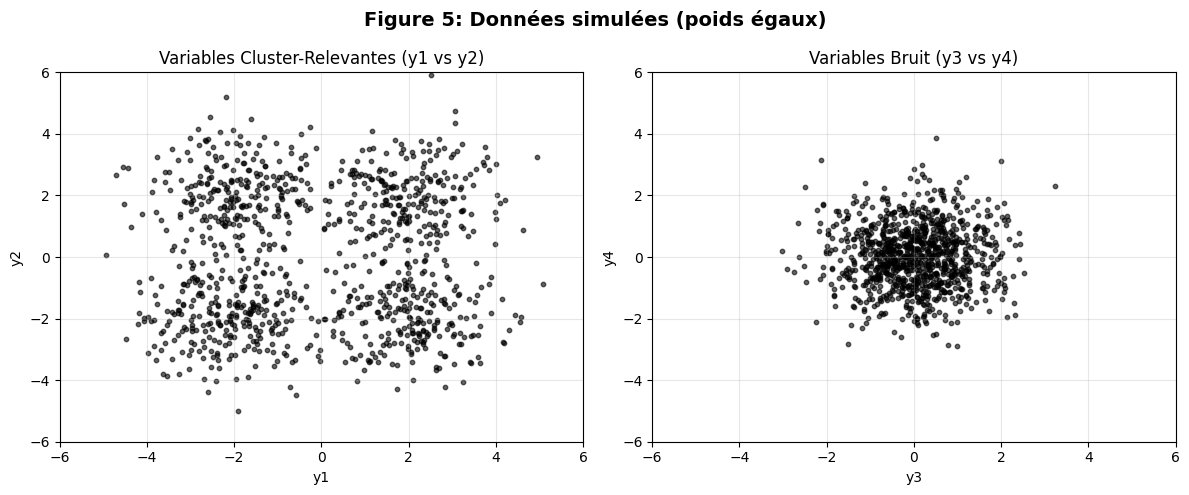


Lancement du MCMC (K=15, 10000 itérations, burn-in=1000)...
Paramètres: e0=0.001, c0=4.0, nu1=0.5, nu2=0.5
Nombre de clusters estimé (Mode K0): 4
Echec du relabeling.


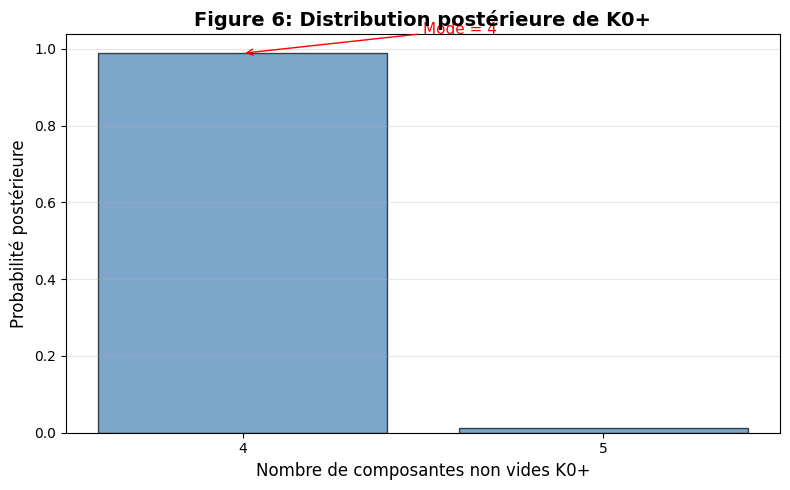

Distribution de K0+: {np.int64(4): np.int64(8896), np.int64(5): np.int64(104)}
Mode de K0+ = 4 (probabilité = 0.988)


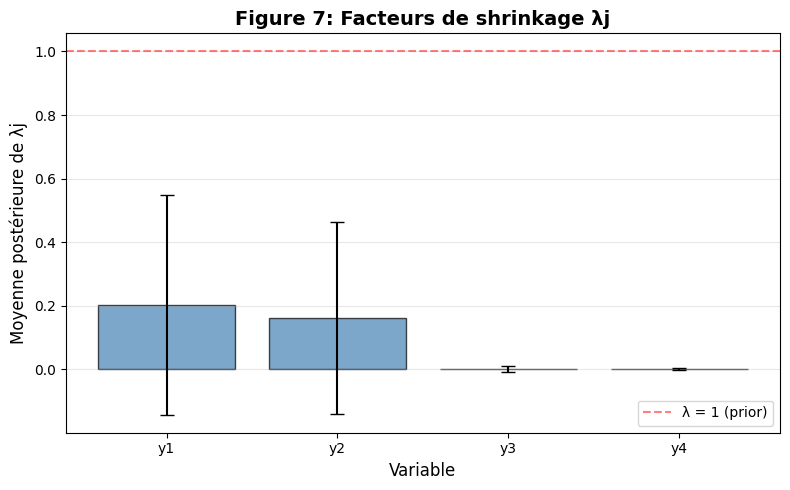

Moyennes postérieures des λj:
  y1: λ = 0.203 ± 0.346 (bruit)
  y2: λ = 0.160 ± 0.302 (bruit)
  y3: λ = 0.001 ± 0.008 (bruit)
  y4: λ = 0.001 ± 0.003 (bruit)


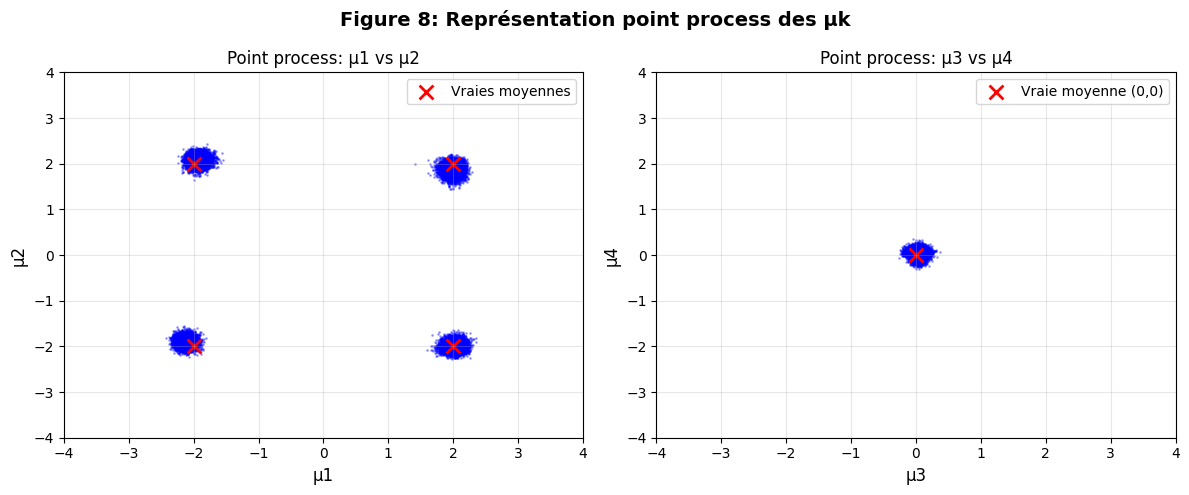

Nombre total de points dans le point process: 35584
Attention: final_mu non disponible, utilisation du dernier état


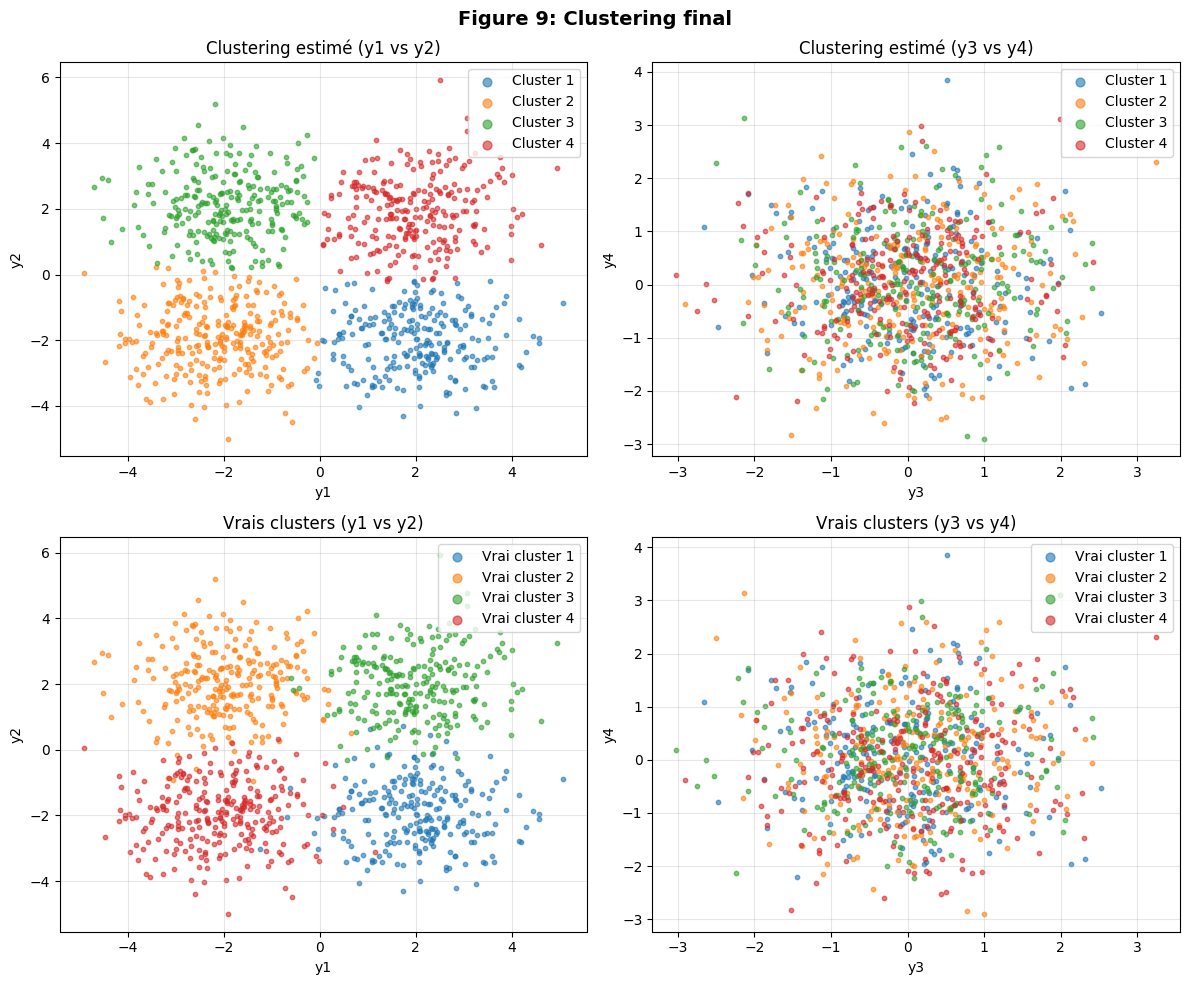

Accuracy du clustering (best permutation): 0.956

RÉSUMÉ DES RÉSULTATS

Nombre de clusters estimé (K̂): 4

Facteurs de shrinkage moyens (λ̂):
  y1: λ = 0.203   bruit
  y2: λ = 0.160   bruit
  y3: λ = 0.001   bruit
  y4: λ = 0.001   bruit



In [18]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# FONCTIONS DE GÉNÉRATION DE DONNÉES (Section 5.1 du papier)
# =============================================================================

def generate_paper_data(n_samples=1000, scenario='equal', seed=42):
    """
    Génère les données synthétiques selon la Section 5.1 du papier.
    
    Args:
        n_samples (int): Nombre d'observations (1000 dans le papier)
        scenario (str): 'equal' ou 'unequal' pour les poids des clusters
        seed (int): Graine aléatoire pour reproductibilité
    
    Returns:
        y (np.ndarray): Les observations (N, 4)
        labels (np.ndarray): Les vrais labels (pour vérification)
    """
    np.random.seed(seed)
    
    # 1. Définition des paramètres (Sect 5.1)
    # Moyennes (Equation dans le texte, page 313)
    # mu1 = (2, -2, 0, 0), mu2 = -mu1, mu3 = (2, 2, 0, 0), mu4 = -mu3
    mu = np.array([
        [ 2, -2, 0, 0],
        [-2,  2, 0, 0],
        [ 2,  2, 0, 0],
        [-2, -2, 0, 0]
    ])
    
    # Covariances (Sigma_k = I_4)
    cov = np.eye(4)
    
    # Poids (Sect 5.1.1 et 5.1.2)
    if scenario == 'equal':
        weights = [0.25, 0.25, 0.25, 0.25]
    elif scenario == 'unequal':
        weights = [0.02, 0.33, 0.33, 0.32]
    else:
        raise ValueError("Scenario doit être 'equal' ou 'unequal'")
        
    # 2. Génération des effectifs par cluster
    n_per_cluster = np.random.multinomial(n_samples, weights)
    
    y_list = []
    labels_list = []
    
    # 3. Échantillonnage des Gaussiennes
    for k, n_k in enumerate(n_per_cluster):
        if n_k > 0:
            cluster_data = np.random.multivariate_normal(mu[k], cov, n_k)
            y_list.append(cluster_data)
            labels_list.append(np.full(n_k, k))
            
    y = np.vstack(y_list)
    labels = np.hstack(labels_list)
    
    # 4. Mélange des données (pour ne pas avoir les clusters ordonnés)
    perm = np.random.permutation(n_samples)
    y = y[perm]
    labels = labels[perm]
    
    return y, labels

# =============================================================================
# FONCTIONS DE VISUALISATION (Figures 5-9 du papier)
# =============================================================================

def plot_figure_5(y, title="Figure 5: Données simulées"):
    """
    Reproduit la Figure 5 du papier :
    - Scatter plot y1 vs y2 (Variables cluster-relevantes)
    - Scatter plot y3 vs y4 (Variables de bruit)
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].scatter(y[:, 0], y[:, 1], s=10, alpha=0.6, c='black')
    axes[0].set_title("Variables Cluster-Relevantes (y1 vs y2)")
    axes[0].set_xlabel("y1")
    axes[0].set_ylabel("y2")
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(-6, 6)
    axes[0].set_ylim(-6, 6)
    
    axes[1].scatter(y[:, 2], y[:, 3], s=10, alpha=0.6, c='black')
    axes[1].set_title("Variables Bruit (y3 vs y4)")
    axes[1].set_xlabel("y3")
    axes[1].set_ylabel("y4")
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim(-6, 6)
    axes[1].set_ylim(-6, 6)
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_figure_6(model, title="Figure 6: Distribution postérieure de K0+"):
    """
    Reproduit la Figure 6 du papier :
    Histogramme de la distribution postérieure du nombre de composantes non vides K0+
    """
    trace_Nk = np.array(model.trace_Nk)
    K0_list = model.K - np.sum(trace_Nk == 0, axis=1)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Histogramme
    vals, counts = np.unique(K0_list, return_counts=True)
    probs = counts / len(K0_list)
    
    ax.bar(vals, probs, color='steelblue', edgecolor='black', alpha=0.7)
    ax.set_xlabel("Nombre de composantes non vides K0+", fontsize=12)
    ax.set_ylabel("Probabilité postérieure", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(range(int(min(vals)), int(max(vals))+1))
    ax.grid(True, alpha=0.3, axis='y')
    
    # Annoter le mode
    mode_idx = np.argmax(counts)
    mode_val = vals[mode_idx]
    ax.annotate(f'Mode = {mode_val}', xy=(mode_val, probs[mode_idx]), 
                xytext=(mode_val + 0.5, probs[mode_idx] + 0.05),
                fontsize=11, color='red',
                arrowprops=dict(arrowstyle='->', color='red'))
    
    plt.tight_layout()
    plt.show()
    
    print(f"Distribution de K0+: {dict(zip(vals, counts))}")
    print(f"Mode de K0+ = {mode_val} (probabilité = {probs[mode_idx]:.3f})")

def plot_figure_7(model, var_names=None, title="Figure 7: Facteurs de shrinkage λj"):
    """
    Reproduit la Figure 7 du papier :
    Moyenne postérieure des facteurs de shrinkage λj pour chaque variable.
    Les variables cluster-relevantes ont λ grand, les variables bruit ont λ petit.
    """
    trace_lambda = np.array(model.trace_lambda)
    mean_lambda = np.mean(trace_lambda, axis=0)
    std_lambda = np.std(trace_lambda, axis=0)
    
    r = len(mean_lambda)
    if var_names is None:
        var_names = [f"y{j+1}" for j in range(r)]
    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    x = np.arange(r)
    bars = ax.bar(x, mean_lambda, yerr=std_lambda, color='steelblue', 
                  edgecolor='black', alpha=0.7, capsize=5)
    
    ax.set_xlabel("Variable", fontsize=12)
    ax.set_ylabel("Moyenne postérieure de λj", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(var_names)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Ligne horizontale pour référence
    ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='λ = 1 (prior)')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("Moyennes postérieures des λj:")
    for j, (name, m, s) in enumerate(zip(var_names, mean_lambda, std_lambda)):
        relevance = "CLUSTER-RELEVANTE" if m > 1 else "bruit"
        print(f"  {name}: λ = {m:.3f} ± {s:.3f} ({relevance})")

def plot_figure_8(model, title="Figure 8: Représentation point process des μk"):
    """
    Reproduit la Figure 8 du papier :
    Scatter plot des draws MCMC des centres μk dans l'espace des paramètres.
    Montre les nuages de points pour chaque composante.
    """
    trace_Nk = np.array(model.trace_Nk)
    K0_list = model.K - np.sum(trace_Nk == 0, axis=1)
    
    # Sélectionner les itérations où K0 = K_hat
    valid_indices = np.where(K0_list == model.K_hat)[0]
    
    # Collecter tous les μ des composantes non vides
    all_mus = []
    for idx in valid_indices:
        active_k = np.where(trace_Nk[idx] > 0)[0]
        for k in active_k:
            all_mus.append(model.trace_mu[idx][k])
    
    all_mus = np.array(all_mus)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # μ1 vs μ2 (variables cluster-relevantes)
    axes[0].scatter(all_mus[:, 0], all_mus[:, 1], s=1, alpha=0.3, c='blue')
    axes[0].set_xlabel("μ1", fontsize=12)
    axes[0].set_ylabel("μ2", fontsize=12)
    axes[0].set_title("Point process: μ1 vs μ2", fontsize=12)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(-4, 4)
    axes[0].set_ylim(-4, 4)
    
    # Marquer les vraies moyennes
    true_mu = np.array([[2, -2], [-2, 2], [2, 2], [-2, -2]])
    axes[0].scatter(true_mu[:, 0], true_mu[:, 1], s=100, c='red', marker='x', 
                    linewidths=2, label='Vraies moyennes')
    axes[0].legend()
    
    # μ3 vs μ4 (variables bruit)
    axes[1].scatter(all_mus[:, 2], all_mus[:, 3], s=1, alpha=0.3, c='blue')
    axes[1].set_xlabel("μ3", fontsize=12)
    axes[1].set_ylabel("μ4", fontsize=12)
    axes[1].set_title("Point process: μ3 vs μ4", fontsize=12)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim(-4, 4)
    axes[1].set_ylim(-4, 4)
    
    # Vraie moyenne (0, 0) pour les variables bruit
    axes[1].scatter([0], [0], s=100, c='red', marker='x', linewidths=2, 
                    label='Vraie moyenne (0,0)')
    axes[1].legend()
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"Nombre total de points dans le point process: {len(all_mus)}")

def plot_figure_9(y, model, true_labels=None, title="Figure 9: Clustering final"):
    """
    Reproduit la Figure 9 du papier :
    Visualisation du clustering final avec les données colorées par cluster assigné.
    """
    # Classifier les données avec les centres estimés
    if hasattr(model, 'final_mu') and model.final_mu is not None:
        # Utiliser les centres finaux pour la classification
        dists = np.zeros((y.shape[0], model.K_hat))
        for k in range(model.K_hat):
            dists[:, k] = np.linalg.norm(y - model.final_mu[k], axis=1)
        predicted_labels = np.argmin(dists, axis=1)
    else:
        # Utiliser le dernier état de S si final_mu n'est pas disponible
        print("Attention: final_mu non disponible, utilisation du dernier état")
        # Fallback: utiliser les derniers mu actifs
        last_Nk = model.trace_Nk[-1]
        last_mu = model.trace_mu[-1]
        active_k = np.where(last_Nk > 0)[0]
        
        dists = np.zeros((y.shape[0], len(active_k)))
        for i, k in enumerate(active_k):
            dists[:, i] = np.linalg.norm(y - last_mu[k], axis=1)
        predicted_labels = np.argmin(dists, axis=1)
    
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Clustering prédit - y1 vs y2
    for k in range(model.K_hat):
        mask = predicted_labels == k
        axes[0, 0].scatter(y[mask, 0], y[mask, 1], s=10, alpha=0.6, 
                          c=[colors[k % 10]], label=f'Cluster {k+1}')
    axes[0, 0].set_xlabel("y1")
    axes[0, 0].set_ylabel("y2")
    axes[0, 0].set_title("Clustering estimé (y1 vs y2)")
    axes[0, 0].legend(markerscale=2)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Clustering prédit - y3 vs y4
    for k in range(model.K_hat):
        mask = predicted_labels == k
        axes[0, 1].scatter(y[mask, 2], y[mask, 3], s=10, alpha=0.6, 
                          c=[colors[k % 10]], label=f'Cluster {k+1}')
    axes[0, 1].set_xlabel("y3")
    axes[0, 1].set_ylabel("y4")
    axes[0, 1].set_title("Clustering estimé (y3 vs y4)")
    axes[0, 1].legend(markerscale=2)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Vrais labels - y1 vs y2
    if true_labels is not None:
        unique_labels = np.unique(true_labels)
        for k in unique_labels:
            mask = true_labels == k
            axes[1, 0].scatter(y[mask, 0], y[mask, 1], s=10, alpha=0.6, 
                              c=[colors[k % 10]], label=f'Vrai cluster {k+1}')
        axes[1, 0].set_xlabel("y1")
        axes[1, 0].set_ylabel("y2")
        axes[1, 0].set_title("Vrais clusters (y1 vs y2)")
        axes[1, 0].legend(markerscale=2)
        axes[1, 0].grid(True, alpha=0.3)
        
        # Vrais labels - y3 vs y4
        for k in unique_labels:
            mask = true_labels == k
            axes[1, 1].scatter(y[mask, 2], y[mask, 3], s=10, alpha=0.6, 
                              c=[colors[k % 10]], label=f'Vrai cluster {k+1}')
        axes[1, 1].set_xlabel("y3")
        axes[1, 1].set_ylabel("y4")
        axes[1, 1].set_title("Vrais clusters (y3 vs y4)")
        axes[1, 1].legend(markerscale=2)
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Calcul de l'accuracy (en tenant compte des permutations)
    if true_labels is not None:
        from itertools import permutations
        best_acc = 0
        for perm in permutations(range(model.K_hat)):
            relabeled = np.array([perm[l] for l in predicted_labels])
            acc = np.mean(relabeled == true_labels)
            best_acc = max(best_acc, acc)
        print(f"Accuracy du clustering (best permutation): {best_acc:.3f}")

def print_summary(model, true_mu=None):
    """Affiche un résumé des résultats comme dans le papier (Table 2)"""
    print("\n" + "="*60)
    print("RÉSUMÉ DES RÉSULTATS")
    print("="*60)
    
    print(f"\nNombre de clusters estimé (K̂): {model.K_hat}")
    
    if hasattr(model, 'final_eta') and model.final_eta is not None:
        print(f"\nPoids estimés (η̂):")
        for k, eta in enumerate(model.final_eta):
            print(f"  Cluster {k+1}: {eta:.4f}")
    
    if hasattr(model, 'final_mu') and model.final_mu is not None:
        print(f"\nCentres estimés (μ̂):")
        for k, mu in enumerate(model.final_mu):
            print(f"  Cluster {k+1}: [{mu[0]:6.3f}, {mu[1]:6.3f}, {mu[2]:6.3f}, {mu[3]:6.3f}]")
        
        if true_mu is not None:
            print(f"\nVrais centres:")
            for k, mu in enumerate(true_mu):
                print(f"  Cluster {k+1}: [{mu[0]:6.3f}, {mu[1]:6.3f}, {mu[2]:6.3f}, {mu[3]:6.3f}]")
    
    # Shrinkage factors
    if hasattr(model, 'trace_lambda') and len(model.trace_lambda) > 0:
        mean_lambda = np.mean(model.trace_lambda, axis=0)
        print(f"\nFacteurs de shrinkage moyens (λ̂):")
        var_names = ['y1', 'y2', 'y3', 'y4']
        for j, (name, lam) in enumerate(zip(var_names, mean_lambda)):
            relevance = "★ CLUSTER-RELEVANTE" if lam > 1 else "  bruit"
            print(f"  {name}: λ = {lam:.3f} {relevance}")
    
    print("\n" + "="*60)

# =============================================================================
# EXÉCUTION DES TESTS (Section 5.1 du papier)
# =============================================================================

# Paramètres comme dans le papier
TRUE_MU = np.array([
    [ 2, -2, 0, 0],
    [-2,  2, 0, 0],
    [ 2,  2, 0, 0],
    [-2, -2, 0, 0]
])

print("="*60)
print("TEST 1: Scénario 'equal weights' (Section 5.1.1)")
print("="*60)

# Génération des données
y_sim, true_labels = generate_paper_data(n_samples=1000, scenario='equal', seed=42)

# Figure 5: Données simulées
plot_figure_5(y_sim, "Figure 5: Données simulées (poids égaux)")

# Entraînement du modèle
print("\nLancement du MCMC (K=15, 10000 itérations, burn-in=1000)...")
print("Paramètres: e0=0.001, c0=4.0, nu1=0.5, nu2=0.5")

model = SparseGaussianMixture(K=15, e0=0.001, c0=2.5 + (4-1)/2, nu1=0.5, nu2=0.5)
model.fit(y_sim, max_iter=10000, burn_in=1000)

# Figure 6: Distribution de K0+
plot_figure_6(model, "Figure 6: Distribution postérieure de K0+")

# Figure 7: Shrinkage factors
plot_figure_7(model, var_names=['y1', 'y2', 'y3', 'y4'], 
              title="Figure 7: Facteurs de shrinkage λj")

# Figure 8: Point process
plot_figure_8(model, "Figure 8: Représentation point process des μk")

# Figure 9: Clustering final
plot_figure_9(y_sim, model, true_labels, "Figure 9: Clustering final")

# Résumé
print_summary(model, TRUE_MU)


TEST 2: Scénario 'unequal weights' (Section 5.1.2)
Poids: [0.02, 0.33, 0.33, 0.32] - Un cluster minoritaire


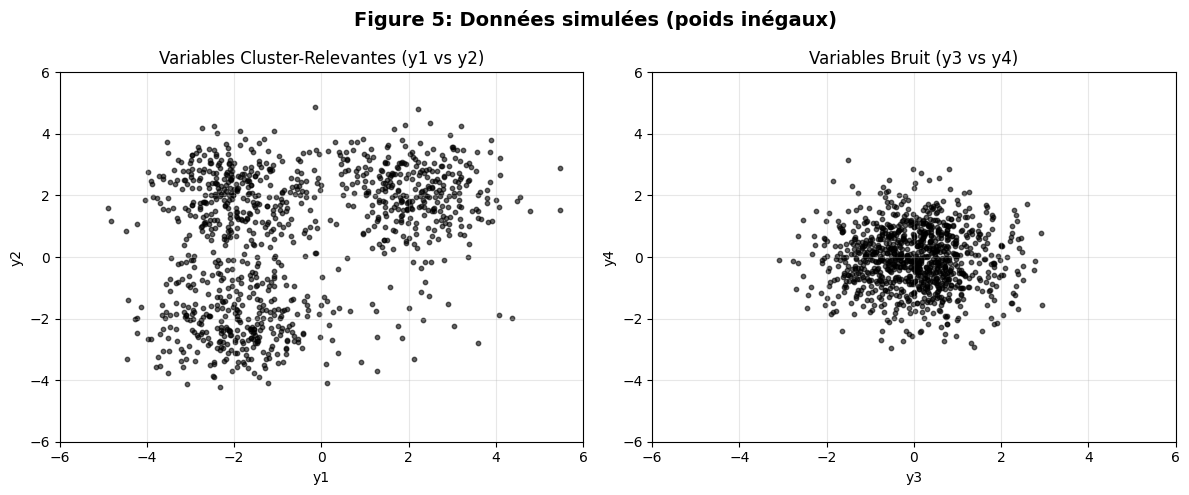


Lancement du MCMC (K=15, 10000 itérations, burn-in=1000)...
Nombre de clusters estimé (Mode K0): 4
Estimation terminée.
Poids finaux : [0.31799528 0.02487386 0.33595408 0.32117678]
Centres finaux : 
[[-1.93974065e+00 -2.02003733e+00 -1.65398035e-03 -4.38157390e-02]
 [ 1.77970183e+00 -1.67571472e+00 -1.58222122e-02  3.02747911e-02]
 [-2.01167775e+00  1.97463352e+00 -3.88688306e-02 -2.87827945e-02]
 [ 2.07297379e+00  2.13527072e+00  6.15319728e-02 -9.38512549e-02]]


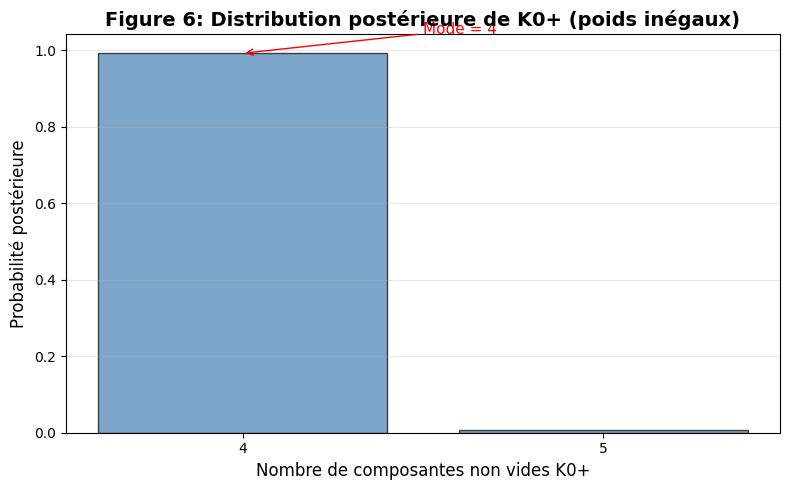

Distribution de K0+: {np.int64(4): np.int64(8933), np.int64(5): np.int64(67)}
Mode de K0+ = 4 (probabilité = 0.993)


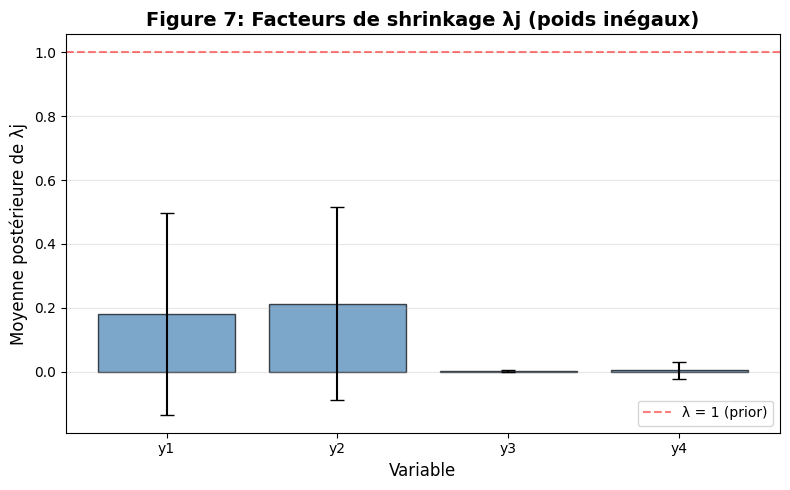

Moyennes postérieures des λj:
  y1: λ = 0.181 ± 0.316 (bruit)
  y2: λ = 0.213 ± 0.302 (bruit)
  y3: λ = 0.001 ± 0.004 (bruit)
  y4: λ = 0.003 ± 0.028 (bruit)


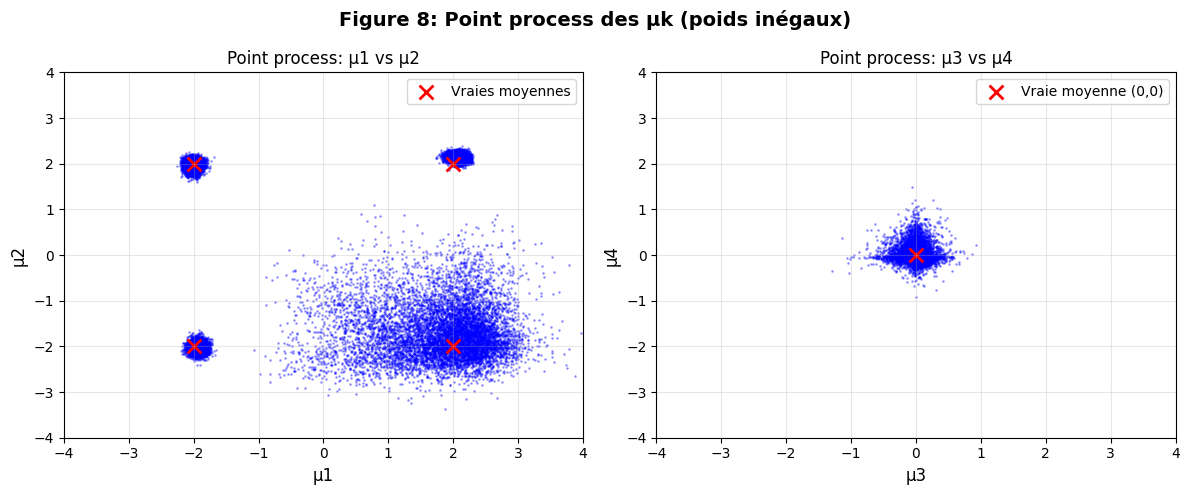

Nombre total de points dans le point process: 35732


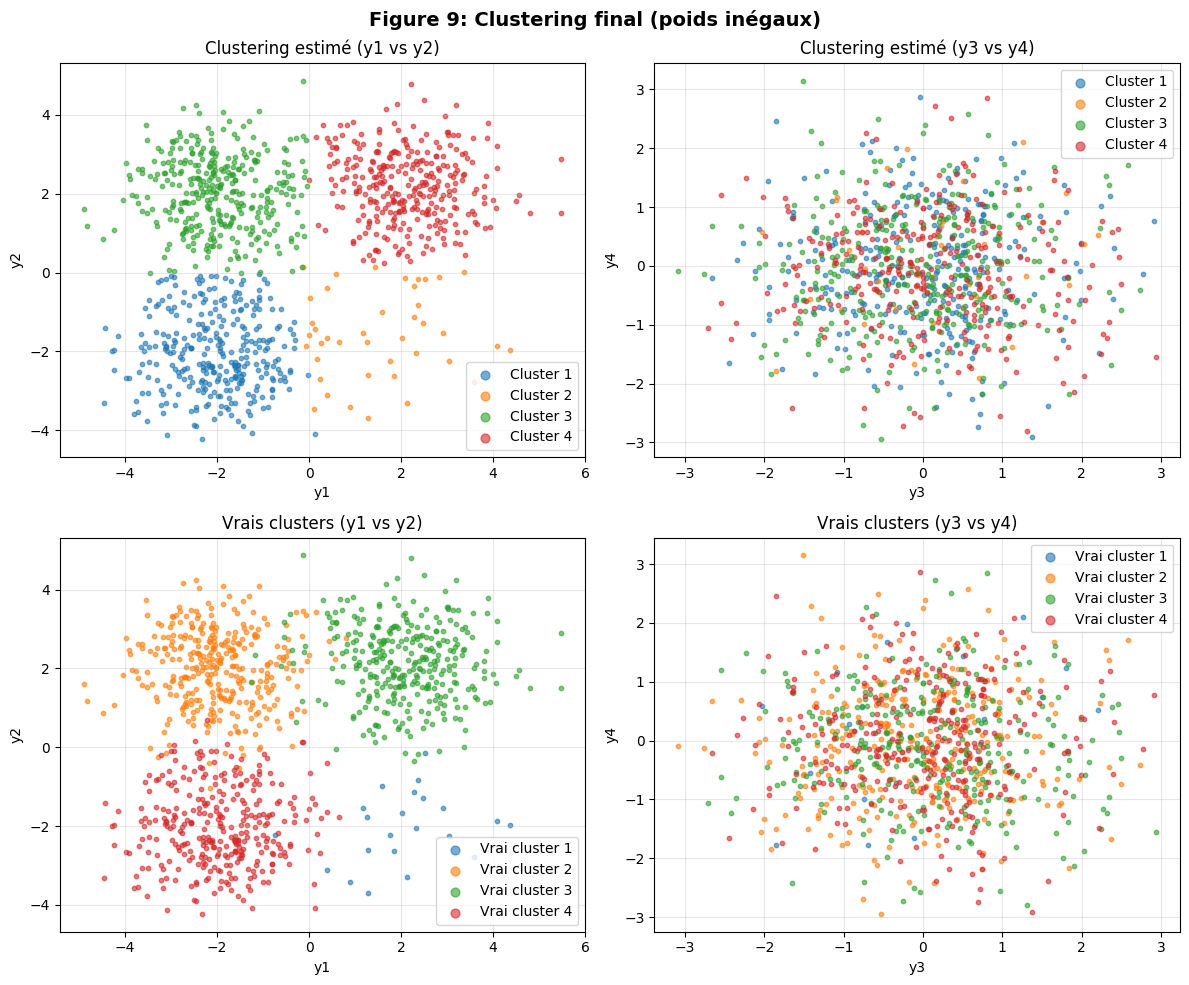

Accuracy du clustering (best permutation): 0.948

RÉSUMÉ DES RÉSULTATS

Nombre de clusters estimé (K̂): 4

Poids estimés (η̂):
  Cluster 1: 0.3180
  Cluster 2: 0.0249
  Cluster 3: 0.3360
  Cluster 4: 0.3212

Centres estimés (μ̂):
  Cluster 1: [-1.940, -2.020, -0.002, -0.044]
  Cluster 2: [ 1.780, -1.676, -0.016,  0.030]
  Cluster 3: [-2.012,  1.975, -0.039, -0.029]
  Cluster 4: [ 2.073,  2.135,  0.062, -0.094]

Vrais centres:
  Cluster 1: [ 2.000, -2.000,  0.000,  0.000]
  Cluster 2: [-2.000,  2.000,  0.000,  0.000]
  Cluster 3: [ 2.000,  2.000,  0.000,  0.000]
  Cluster 4: [-2.000, -2.000,  0.000,  0.000]

Facteurs de shrinkage moyens (λ̂):
  y1: λ = 0.181   bruit
  y2: λ = 0.213   bruit
  y3: λ = 0.001   bruit
  y4: λ = 0.003   bruit



In [19]:
# =============================================================================
# TEST 2: Scénario 'unequal weights' (Section 5.1.2 du papier)
# =============================================================================
# Ce scénario est plus difficile car un cluster a seulement 2% des données

print("\n" + "="*60)
print("TEST 2: Scénario 'unequal weights' (Section 5.1.2)")
print("Poids: [0.02, 0.33, 0.33, 0.32] - Un cluster minoritaire")
print("="*60)

# Génération des données avec poids inégaux
y_sim_uneq, true_labels_uneq = generate_paper_data(n_samples=1000, scenario='unequal', seed=123)

# Figure 5: Données simulées
plot_figure_5(y_sim_uneq, "Figure 5: Données simulées (poids inégaux)")

# Entraînement du modèle
print("\nLancement du MCMC (K=15, 10000 itérations, burn-in=1000)...")
model_uneq = SparseGaussianMixture(K=15, e0=0.001, c0=2.5 + (4-1)/2, nu1=0.5, nu2=0.5)
model_uneq.fit(y_sim_uneq, max_iter=10000, burn_in=1000)

# Figures
plot_figure_6(model_uneq, "Figure 6: Distribution postérieure de K0+ (poids inégaux)")
plot_figure_7(model_uneq, var_names=['y1', 'y2', 'y3', 'y4'], 
              title="Figure 7: Facteurs de shrinkage λj (poids inégaux)")
plot_figure_8(model_uneq, "Figure 8: Point process des μk (poids inégaux)")
plot_figure_9(y_sim_uneq, model_uneq, true_labels_uneq, "Figure 9: Clustering final (poids inégaux)")

# Résumé
print_summary(model_uneq, TRUE_MU)
